# Enter your name and student ID number in this box.

Use the form of Last Name, First Name, ISU student ID: Sai Chandana Vallam Kondu, 023810339


# HW 3: CIFAR-10 Classification: PyTorch Implementation

In this assignment, you will be classifying the contents of the ten types of images in the CIFAR10 dataset. The implementation will be in PyTorch.

THe learning objectives of the assignment are:

    Learn to use the PyTorch ML framework for creating and training deep networks.
    Learn a structured approach to setting up models, training and testing.
    Experiment with and explain different types of regularization in training networks.

In the last section of the assignment, there are questions that you need to answer about model performance and the concepts for characterizing performance. You may answer the questions in the run notebook that you submit or in a separate pdf document. Since much of the model has been created for you, most of the points in the project will come from your answers.

This notebook was beautifully created by TA Mr. Samuel Fanijo with comments and text by Dr. Julie A Dickerson at Iowa State University. 2023.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR # @Sai: added the library

# if you have not installed torchvision or it is missing your installation, need to run the following line
!pip3 install torchvision
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

In [ ]:
# Define device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])


## 1.  Function to get training, validation, and test datasets
This function uses the built-in torchvision datasets that includes many of the standard datasets used to compare networks. Please see <a href="<a href="https://pytorch.org/vision/main/datasets.html" target="_blank" rel="noopener">Torchvision Datasets</a> for more information.
    
Data transformations transform and normalize the data for your network.



In [ ]:
# Function to get training, validation, and test datasets
def get_datasets(transform, batch_size):
    """
    Loads the CIFAR-10 dataset, applies transformations, and splits it into training, validation, and test sets.

    Args:
    - transform: PyTorch transformation to apply to the data.

    Returns:
    - trainloader: DataLoader for the training set.
    - valloader: DataLoader for the validation set.
    - testloader: DataLoader for the test set.
    """
    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Split the training dataset into training and validation
    num_train = len(trainset)
    indices = list(range(num_train))
    split = int(np.floor(0.2 * num_train))

    np.random.seed(42)
    np.random.shuffle(indices)

    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

    # Create data loaders for training, validation, and test
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader, testloader


In [ ]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 2. Define neural network model
The model set up here is an initial model with three layers. The input layer is size [3072, 512], the hidden layer is [512,256] and the output layer is [256,10]. The activations for the input and hidden layers are the relu function and the output activation will be a softmax function with the cross-entropy loss.

The *init* function defines the layers. The *forward* function defines the forward pass. Note that we are not explicitly adding the softmax function in the output layer. We will instead used the defined function cross-entropy loss that implements both the softmax and the cross-entropy loss.

I strongly suggest that you look at the documentation for the *nn* package in PyTorch to understand the layer types.

In [ ]:
# Define fully connected neural network model
class FCNet(nn.Module):
    """
    A fully connected neural network model for image classification on the CIFAR-10 dataset.

    Architecture:
    - Input: Flattened feature vectors of size 3*32*32
    - Fully Connected Layer 1: 3*32*32 to 512 neurons with ReLU activation
    - Fully Connected Layer 2: 512 to 256 neurons with ReLU activation
    - Fully Connected Layer 3: 256 to 10 output neurons (for 10 classes)

    This network is designed for image classification task with the input data as
    flattened feature vectors. It uses densely connected layers (fully connected layers)
    with ReLU activations to learn the spatial features and relationships in the data.

    Attributes:
    - fc1: First fully connected layer.
    - fc2: Second fully connected layer.
    - fc3: Output layer with 10 classes for CIFAR-10.

    Methods:
    - forward(x): Defines the forward pass of the network.
    """

    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # Input size 3*32*32, output size 512
        self.fc2 = nn.Linear(512, 256)  # Hidden layer with 256 neurons
        self.fc3 = nn.Linear(256, 10)  # Output layer with 10 classes

    def forward(self, x):
        """
        Defines the forward pass of the fully connected neural network.

        Args:
        - x: Input feature vector (flattened image).

        Returns:
        - x: Output tensor representing class scores.
        """
        x = x.view(-1, 3 * 32 * 32)  # Flatten the input tensor into a vector
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = self.fc3(x)  # Output layer
        return x

## 3. Function to train the neural network using training set
The functions below use the data loader capabilities to train your network and check the validation and testing data against your trained network. You will not have to make any changes to this function but you should be able to explain how it works.

In [ ]:
# Function to train the neural network using training set
def train_model(model, trainloader, optimizer, criterion, device):
    """
    Trains the neural network on the training dataset.

    Args:
    - model: PyTorch neural network model.
    - trainloader: DataLoader for the training set.
    - optimizer: PyTorch optimizer.
    - criterion: Loss function.
    - device: Device to run the training on (CPU or GPU).

    Returns:
    - train_loss: Average training loss for the epoch.
    - train_accuracy: Training accuracy for the epoch.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients to avoid accumulation

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()  # Accumulate the loss

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    return running_loss / len(trainloader), train_accuracy

### Function to validate the neural network using validation set

In [ ]:
# Function to validate the neural network using validation set
def validate_model(model, valloader, device):
    """
    Validates the neural network on the validation dataset.

    Args:
    - model: PyTorch neural network model.
    - valloader: DataLoader for the validation set.
    - device: Device to run the validation on (CPU or GPU).

    Returns:
    - val_accuracy: Validation accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    return val_accuracy


### Function to test the model using test set

In [ ]:
# Function to test the neural network using test set
def test_model(model, testloader, device):
    """
    Tests the trained neural network on the test dataset.

    Args:
    - model: PyTorch neural network model.
    - testloader: DataLoader for the test set.
    - device: Device to run the testing on (CPU or GPU).

    Returns:
    - test_accuracy: Test accuracy.
    - true_labels: True labels of test samples.
    - predicted_labels: Predicted labels by the model.
    """
    model.eval()
    correct_test = 0
    total_test = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test

    return test_accuracy, true_labels, predicted_labels

## 4. Define optimizer
In this function, you will need to select which optimizer to use. We have given you 2 different examples. PyTorch has multiple optimizers defined in the [torch.optim](/https://pytorch.org/docs/stable/optim.html) package. You will need to implement two different options from the extensive list of functions and discuss the results

In [ ]:
# Function to select an optimizer
def select_optimizer(optimizer_option, model):
    """
    Define an optimizer for training.

    Returns:
    - optimizer: PyTorch optimizer.
    """
    if optimizer_option == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_option == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_option == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    else:
        raise ValueError("Invalid optimizer option")

    return optimizer

### 5. Main: putting everything together
When you run this block, it will ask you to enter in the batch size (try 32, 64 or 128) and which optimizer to use at the bottom (this is hard-coded and you will replace the value). You can also set the number of epochs to train over in the main function.

In [ ]:
# Main function to run the deep learning pipeline
def main(optimizer_option, batch_size, num_epochs):
    """
    Main function to run the model with specified optimizer.

    Args:
    - optimizer_option (may or may not be hardcoded)
    - batch size for training.
    """

    ##################### Define run parameters #########################################
    # Get datasets
    trainloader, valloader, testloader = get_datasets(transform, batch_size)

    # Initialize the model
    model = FCNet().to(device)

    # Select optimizer based on user's choice
    optimizer = select_optimizer(optimizer_option, model)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Lists to store training and validation accuracy
    train_accuracy_list = []
    val_accuracy_list = []

    # Set Number of epochs to train model for
    # num_epochs = 10
    #======================
    # @Sai: Changed to input variable
    #======================
    num_epochs = num_epochs

    ####################################################################################


    # Train the model for multiple epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, trainloader, optimizer, criterion, device)
        val_accuracy = validate_model(model, valloader, device)

        # Append accuracy values to lists for later plotting
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%')

    print('Finished Training')

    # Test the model
    test_accuracy, true_labels, predicted_labels = test_model(model, testloader, device)

    print(f'Test Accuracy: {test_accuracy}%')

    # Calculate classification report
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot unnormalized confusion matrix
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Unnormalized)')

    # Plot normalized confusion matrix
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.subplot(1, 2, 2)
    sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalized)')
    plt.tight_layout()
    plt.show()

    # Randomly select 10 samples for testing
    print("")
    print("Randomly Select 10 Samples for Testing:")
    random_indices = random.sample(range(len(testloader.dataset)), 10)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        image, label = testloader.dataset[idx]
        image = image / 2 + 0.5  # Unnormalize
        np_image = image.numpy()
        plt.imshow(np.transpose(np_image, (1, 2, 0)))
        actual_label = class_names[label]
        predicted_label = class_names[predicted_labels[idx]]
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    plt.show()


100%|██████████| 170498071/170498071 [00:02<00:00, 76066332.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1, Loss: 1.949190079498291, Training Accuracy: 31.3375%, Validation Accuracy: 38.03%
Epoch 2, Loss: 1.6603675664901734, Training Accuracy: 41.555%, Validation Accuracy: 42.93%
Epoch 3, Loss: 1.5474962379455566, Training Accuracy: 45.5925%, Validation Accuracy: 45.41%
Epoch 4, Loss: 1.4641902848720552, Training Accuracy: 48.845%, Validation Accuracy: 47.69%
Epoch 5, Loss: 1.3921848232746123, Training Accuracy: 51.26%, Validation Accuracy: 50.06%
Epoch 6, Loss: 1.3297079665184022, Training Accuracy: 53.56%, Validation Accuracy: 50.67%
Epoch 7, Loss: 1.2734210097789764, Training Accuracy: 55.605%, Validation Accuracy: 51.22%
Epoch 8, Loss: 1.2236186594963074, Training Accuracy: 57.295%, Validation Accuracy: 52.73%
Epoch 9, Loss: 1.174677698945999, Training Accuracy: 59.1575%, Validation Accuracy: 52.81%
Epoch 10, Loss: 1.128997275018692, Training Accuracy: 60.67%, Validation Accuracy: 52.73%
Fin

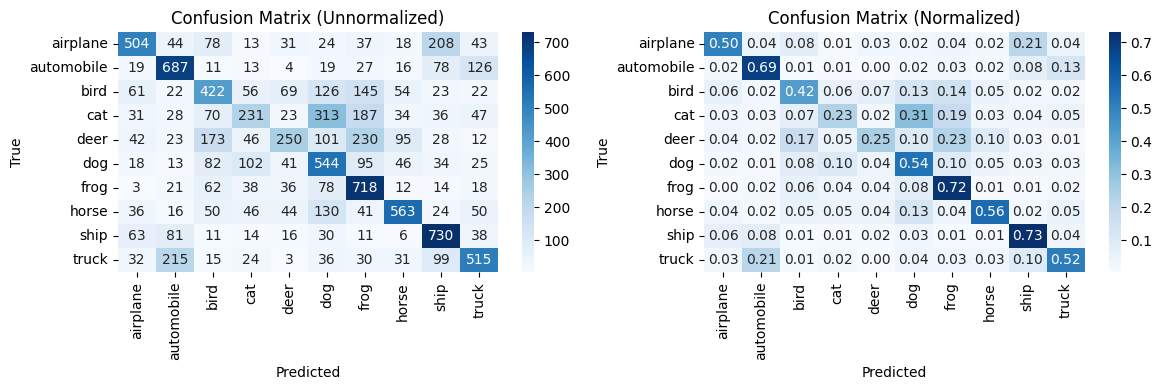


Randomly Select 10 Samples for Testing:


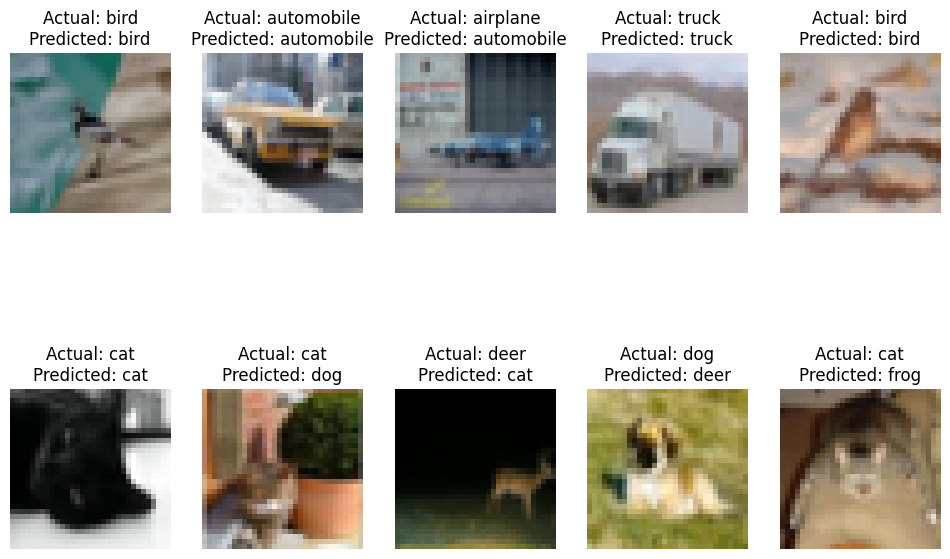

In [ ]:
# Case-0: Provided by instructor/TAs
if __name__ == "__main__":
    # Select the optimizer option
    #optimizer_option = input("Select optimizer option (adam,  momentum, SGD): ")
    optimizer_option = "SGD" #changed to an hardcoded version
    # Select the batch size for training
    # batch_size = int(input("Enter batch size: "))
    batch_size = 32 #changed to an hardcoded version
    num_epochs = 10
    main(optimizer_option, batch_size, num_epochs)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.68547938079834, Training Accuracy: 40.1925%, Validation Accuracy: 44.01%
Epoch 2, Loss: 1.4813214978694915, Training Accuracy: 47.41%, Validation Accuracy: 48.42%
Epoch 3, Loss: 1.3779188934326172, Training Accuracy: 51.0625%, Validation Accuracy: 48.76%
Epoch 4, Loss: 1.2891568253517152, Training Accuracy: 54.7875%, Validation Accuracy: 50.14%
Epoch 5, Loss: 1.2078742720603943, Training Accuracy: 57.08%, Validation Accuracy: 50.91%
Epoch 6, Loss: 1.1380141427993775, Training Accuracy: 59.54%, Validation Accuracy: 51.19%
Epoch 7, Loss: 1.058317599773407, Training Accuracy: 62.53%, Validation Accuracy: 51.55%
Epoch 8, Loss: 0.9938382357358932, Training Accuracy: 64.4575%, Validation Accuracy: 50.55%
Epoch 9, Loss: 0.9224450011491776, Training Accuracy: 67.0075%, Validation Accuracy: 51.17%
Epoch 10, Loss: 0.8622461401939392, Training Accuracy: 69.22%, Validation Accuracy: 51.1%
Finished Training

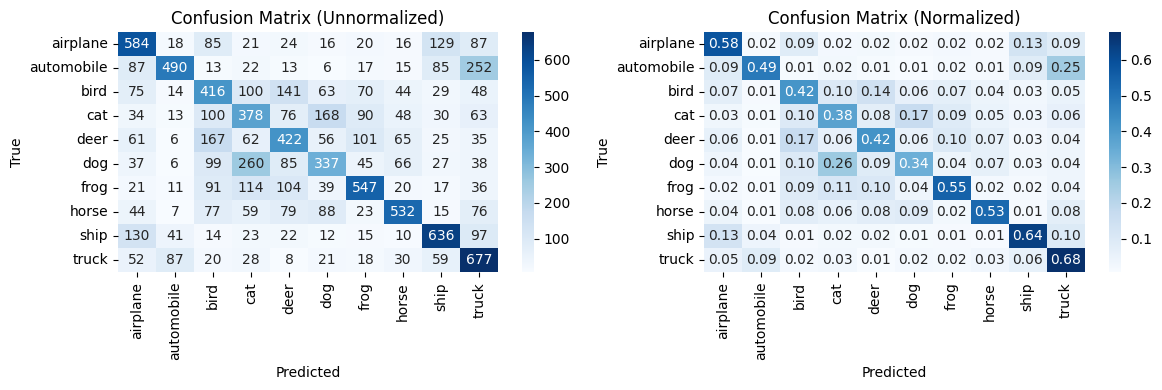


Randomly Select 10 Samples for Testing:


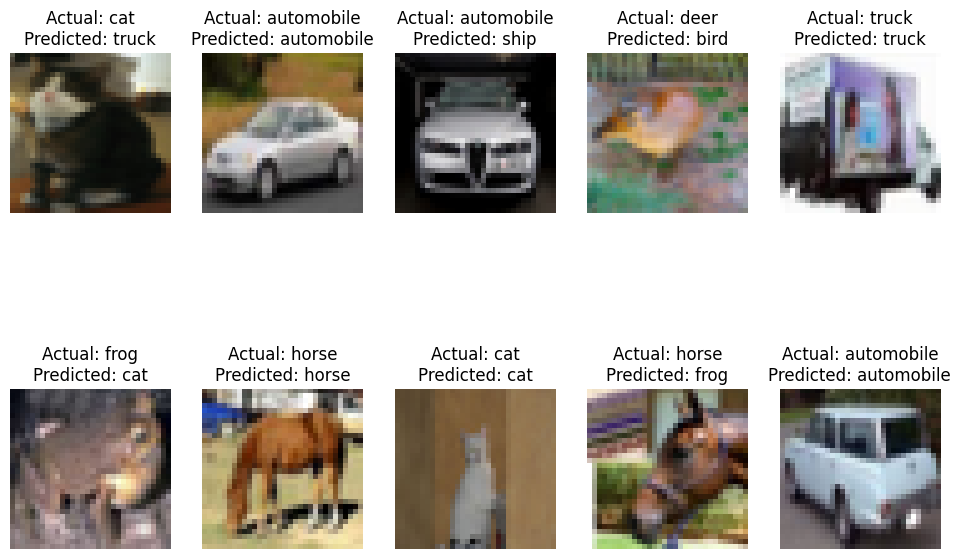

In [ ]:
# Case-1: Changed optimizer to adam
if __name__ == "__main__":
    # Select the optimizer option
    #optimizer_option = input("Select optimizer option (adam,  momentum, SGD): ")
    optimizer_option = "adam" #changed to an hardcoded version
    # Select the batch size for training
    # batch_size = int(input("Enter batch size: "))
    batch_size = 32 #changed to an hardcoded version
    num_epochs = 10
    main(optimizer_option, batch_size, num_epochs)



```
# New Code scripts prepared by Sai Chandana


> Flexible neural net
> Updated main function


```



## 2a. [Updated] the given neural network model with dynamic layers and new hyperparameters
After several experiments, I thought of building generic FCNet model with dynamic hidden layers, dimentions, activation functions, batch normalization. Here is my codeset of the udated FCNet model.

In [ ]:
class FCNet_generic_BN_sai(nn.Module):
    """
    A flexible fully connected neural network model with input flattening and dynamic layers.

    Attributes:
    - input_dim: Input dimension for the feature vector.
    - hidden_dims: List of dimensions for hidden layers.
    - activations: List of activation functions for each hidden layer.
    - output_dim: Output dimension (number of classes).

    Methods:
    - __init__(input_dim, hidden_dims, activations, output_dim): Initializes the model.
    - forward(x): Defines the forward pass of the network.
    """

    def __init__(self, input_dim, hidden_dims, activations, output_dim):
        super(FCNet_generic_BN_sai, self).__init__()

        # Check if the number of hidden layers, dimensions, and activations match
        if len(hidden_dims) != len(activations):
            raise ValueError("Number of hidden layers must match the number of activation functions.")

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.activations = activations

        # Create the input layer
        self.layers = [nn.Linear(input_dim, hidden_dims[0])]
        self.layers.append(nn.BatchNorm1d(hidden_dims[0]))  # Batch normalization
        self.layers.append(activations[0])

        # Create hidden layers with specified dimensions and activations
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            self.layers.append(nn.BatchNorm1d(hidden_dims[i]))  # Batch normalization
            self.layers.append(activations[i])

        # Create the output layer
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))

        # Define the model using nn.Sequential
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        """
        Defines the forward pass of the fully connected neural network.

        Args:
        - x: Input feature vector.

        Returns:
        - x: Output tensor representing class scores.
        """
        x = x.view(-1, self.input_dim)  # Flatten the input tensor into a vector
        return self.model(x)


## 4a. [Updated] the given optimizer with weidgt_decay and added new optimzers
I have added two more optimizers rmsprop and adagrad from torch.optim library. I have also added weight_decay optimizer, which is one of the common techniques of adding a regularization term to the loss function to prevent overfitting. Here is the updated code script.

In [ ]:
# Function to select an optimizer
def select_optimizer_sai(optimizer_option, model, learning_rate):
    """
    Define an optimizer for training.
    Adding weight decay to an optimizer is a common technique to prevent overfitting by adding a regularization term to the loss function.
    Here, I added weight decay (5e-4) to the optimizers, which is generally a reasonable practice.
    However, it's important to be aware of how weight decay works and to choose an appropriate value for the specific problem.

    Returns:
    - optimizer: PyTorch optimizer.


    """
    if optimizer_option == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    elif optimizer_option == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    elif optimizer_option == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    #======================
    # @Sai: Added rmsprop and adagrad Algorithms from torch.optim package: https://pytorch.org/docs/stable/optim.html
    #======================
    elif optimizer_option == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.9, weight_decay=5e-4)
    elif optimizer_option == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    #======================
    else:
        raise ValueError("Invalid optimizer option")

    return optimizer

### 5a. [Updated] the Main function and used my updated FCNet_generic_BN_Sai function, and Scheduler.
I try to keep the Main as consistent as possible. I have updated it with my FCNet generic model and scheduler. Here is the updated code script.

In [ ]:
# Main function to run the deep learning pipeline
def main_sai(optimizer_option, batch_size, num_epochs, input_dim, hidden_dims, activations, output_dim, learning_rate):
    """
    Main function to run the model with specified optimizer.

    Args:
    - optimizer_option (may or may not be hardcoded)
    - batch size for training.
    """

    ##################### Define run parameters #########################################
    # Get datasets
    trainloader, valloader, testloader = get_datasets(transform, batch_size)

    # Initialize the model
    model = FCNet_generic_BN_sai(input_dim, hidden_dims, activations, output_dim).to(device)

    # Select optimizer based on user's choice
    optimizer = select_optimizer_sai(optimizer_option, model, learning_rate)

    # Define the CosineAnnealingLR scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=200)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Lists to store training and validation accuracy
    train_accuracy_list = []
    val_accuracy_list = []

    # Set Number of epochs to train model for
    # num_epochs = 10
    #======================
    # @Sai: Changed to input variable
    #======================
    num_epochs = num_epochs

    ####################################################################################

    # Train the model for multiple epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, trainloader, optimizer, criterion, device)
        val_accuracy = validate_model(model, valloader, device)

        # Append accuracy values to lists for later plotting
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)

        # Update the learning rate at the end of each epoch
        scheduler.step()

        print(f'Epoch {epoch + 1}, Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%')

    print('Finished Training')

    # Test the model
    test_accuracy, true_labels, predicted_labels = test_model(model, testloader, device)

    print(f'Test Accuracy: {test_accuracy}%')

    # Calculate classification report
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot unnormalized confusion matrix
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Unnormalized)')

    # Plot normalized confusion matrix
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.subplot(1, 2, 2)
    sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalized)')
    plt.tight_layout()
    plt.show()

    # Randomly select 10 samples for testing
    print("")
    print("Randomly Select 10 Samples for Testing:")
    random_indices = random.sample(range(len(testloader.dataset)), 10)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        image, label = testloader.dataset[idx]
        image = image / 2 + 0.5  # Unnormalize
        np_image = image.numpy()
        plt.imshow(np.transpose(np_image, (1, 2, 0)))
        actual_label = class_names[label]
        predicted_label = class_names[predicted_labels[idx]]
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    plt.show()


{'hidden_dims': [512, 256], 'activations': [ReLU(), ReLU()], 'learning_rate': 0.01, 'optimizer': 'SGD'}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.6571593772888185, Training Accuracy: 41.5025%, Validation Accuracy: 46.7%
Epoch 2, Loss: 1.4451251056671142, Training Accuracy: 48.855%, Validation Accuracy: 50.44%
Epoch 3, Loss: 1.342859101009369, Training Accuracy: 52.4525%, Validation Accuracy: 50.9%
Epoch 4, Loss: 1.264755224752426, Training Accuracy: 55.1425%, Validation Accuracy: 51.87%
Epoch 5, Loss: 1.2051517962932587, Training Accuracy: 57.505%, Validation Accuracy: 53.26%
Epoch 6, Loss: 1.1463957204818727, Training Accuracy: 59.6075%, Validation Accuracy: 53.15%
Epoch 7, Loss: 1.0991164248943328, Training Accuracy: 61.27%, Validation Accuracy: 54.47%
Epoch 8, Loss: 1.049552375125885, Training Accuracy: 63.3675%, Validation Accuracy: 54.17%
Epoch 9, Loss: 1.0061039795398712, Training Accuracy: 64.945%, Validation Accuracy: 53.82%
Ep

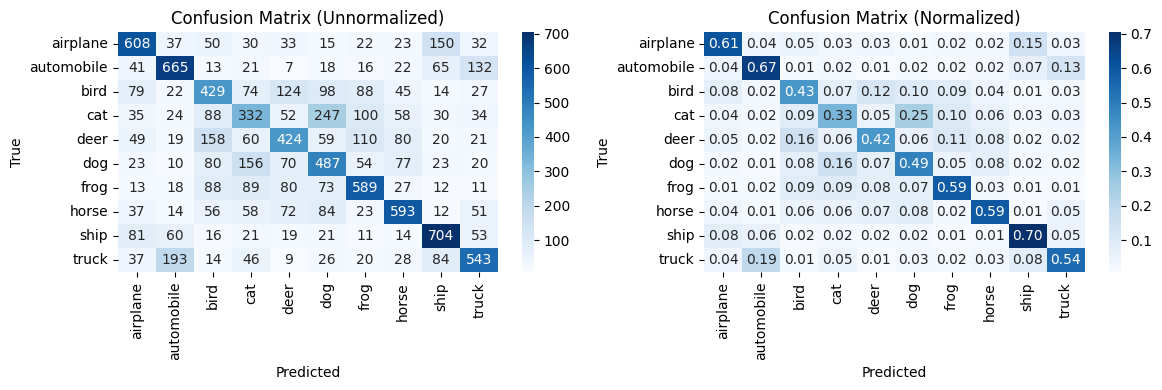


Randomly Select 10 Samples for Testing:


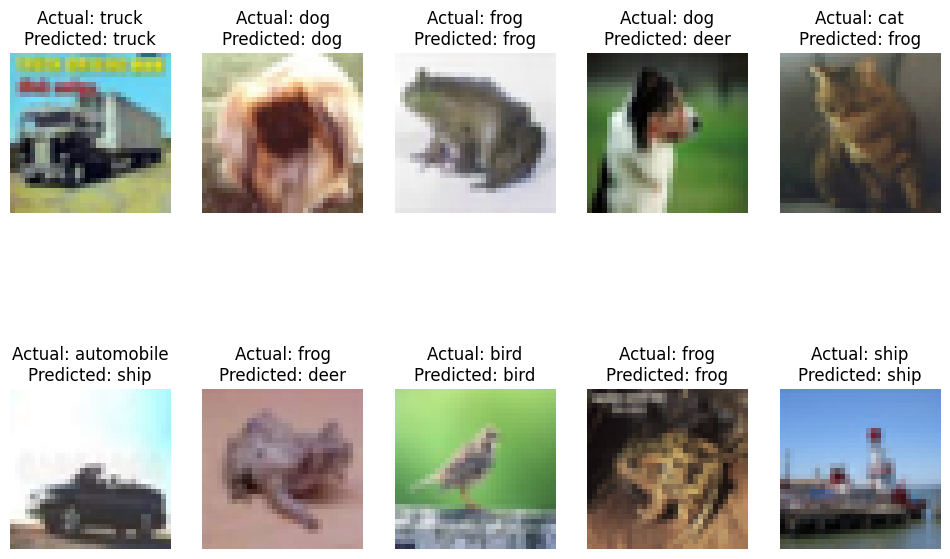

{'hidden_dims': [512, 256], 'activations': [ReLU(), ReLU()], 'learning_rate': 0.01, 'optimizer': 'adam'}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.8894248545646668, Training Accuracy: 31.61%, Validation Accuracy: 35.01%
Epoch 2, Loss: 1.8056718260765077, Training Accuracy: 34.835%, Validation Accuracy: 35.17%
Epoch 3, Loss: 1.786602059841156, Training Accuracy: 35.3775%, Validation Accuracy: 37.15%
Epoch 4, Loss: 1.769761295890808, Training Accuracy: 36.2775%, Validation Accuracy: 37.44%
Epoch 5, Loss: 1.76455515499115, Training Accuracy: 36.4075%, Validation Accuracy: 36.35%
Epoch 6, Loss: 1.7610785654067993, Training Accuracy: 36.7075%, Validation Accuracy: 35.89%
Epoch 7, Loss: 1.7561467638015746, Training Accuracy: 36.7725%, Validation Accuracy: 39.88%
Epoch 8, Loss: 1.749939402103424, Training Accuracy: 36.8175%, Validation Accuracy: 36.11%
Epoch 9, Loss: 1.746628929710388, Training Accuracy: 37.205%, Validation Accuracy: 37.61%
E

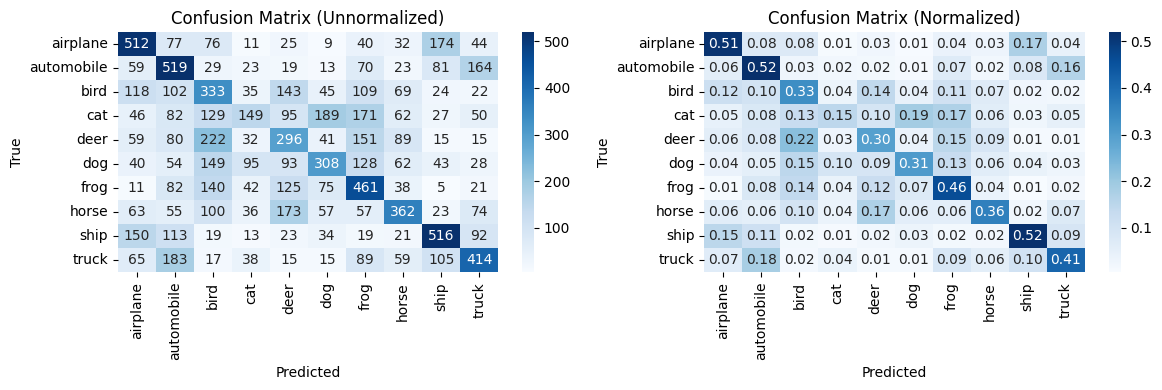


Randomly Select 10 Samples for Testing:


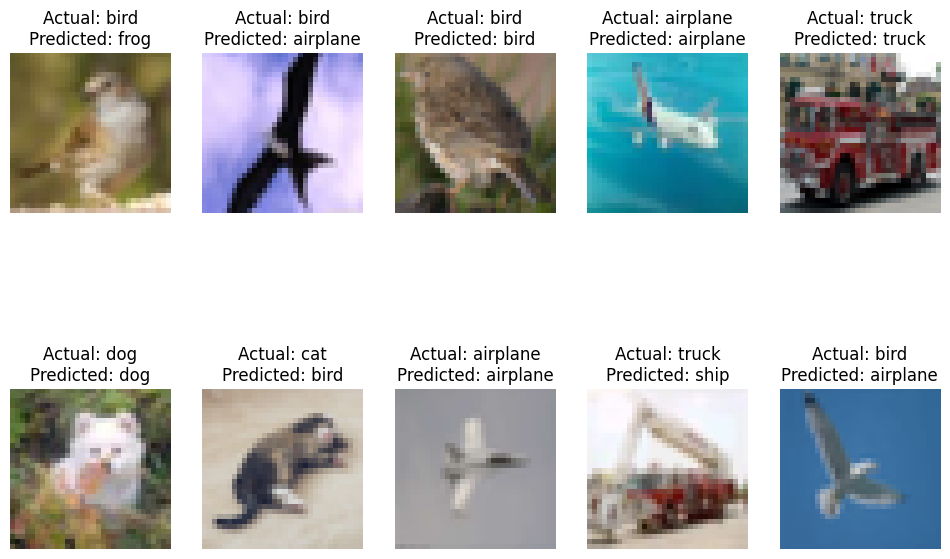

{'hidden_dims': [512, 256], 'activations': [ReLU(), ReLU()], 'learning_rate': 0.001, 'optimizer': 'adam'}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.6798261463165283, Training Accuracy: 39.82%, Validation Accuracy: 44.82%
Epoch 2, Loss: 1.5355823580741883, Training Accuracy: 45.0975%, Validation Accuracy: 46.77%
Epoch 3, Loss: 1.4830319455623626, Training Accuracy: 46.8875%, Validation Accuracy: 48.11%
Epoch 4, Loss: 1.4370779079914093, Training Accuracy: 48.51%, Validation Accuracy: 48.03%
Epoch 5, Loss: 1.4040044348716736, Training Accuracy: 50.015%, Validation Accuracy: 49.75%
Epoch 6, Loss: 1.371737093925476, Training Accuracy: 51.2575%, Validation Accuracy: 50.51%
Epoch 7, Loss: 1.353616777420044, Training Accuracy: 51.465%, Validation Accuracy: 50.86%
Epoch 8, Loss: 1.3337446593284608, Training Accuracy: 52.47%, Validation Accuracy: 50.9%
Epoch 9, Loss: 1.319490853691101, Training Accuracy: 52.86%, Validation Accuracy: 50.36%
Epoc

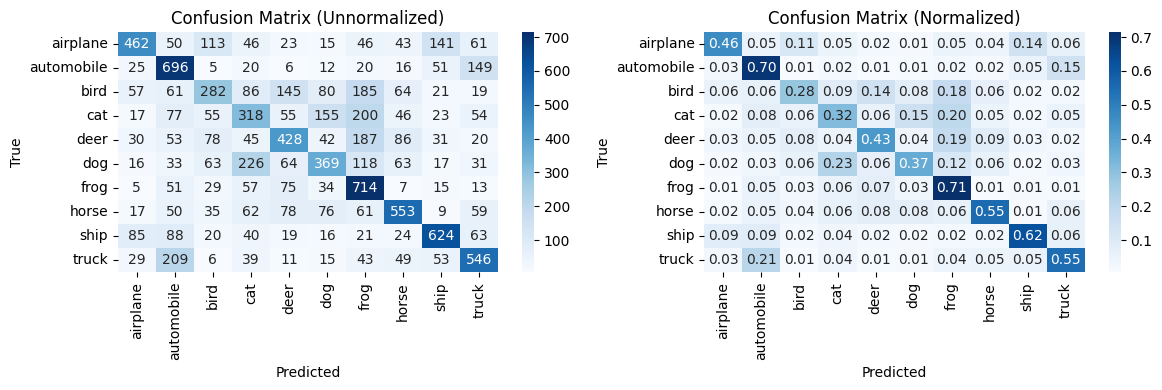


Randomly Select 10 Samples for Testing:


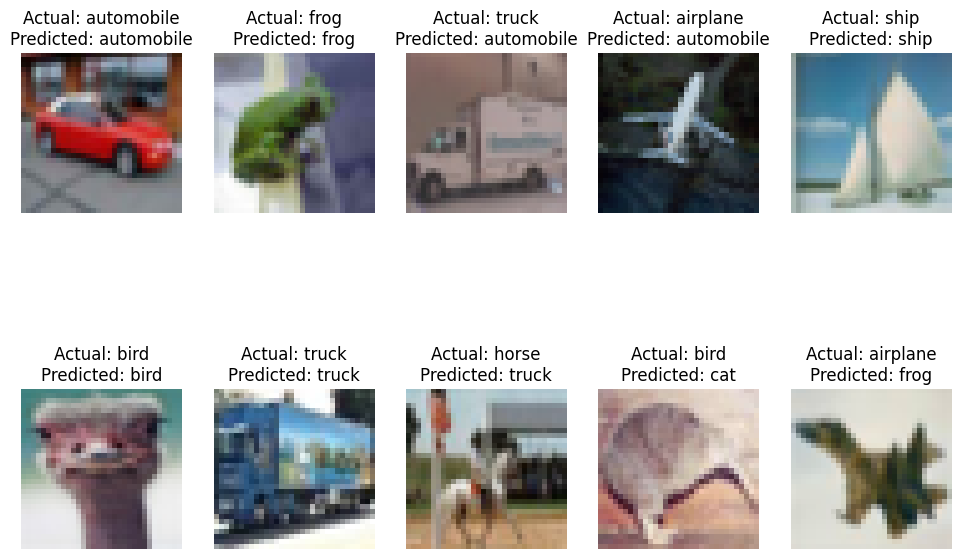

{'hidden_dims': [512, 256, 16], 'activations': [ReLU(), ReLU(), ReLU()], 'learning_rate': 0.01, 'optimizer': 'adam'}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.903157691192627, Training Accuracy: 30.675%, Validation Accuracy: 34.77%
Epoch 2, Loss: 1.8374465133666993, Training Accuracy: 33.1025%, Validation Accuracy: 34.34%
Epoch 3, Loss: 1.8147529970169067, Training Accuracy: 34.1675%, Validation Accuracy: 34.62%
Epoch 4, Loss: 1.806795188140869, Training Accuracy: 34.7275%, Validation Accuracy: 35.61%
Epoch 5, Loss: 1.802027445411682, Training Accuracy: 34.9325%, Validation Accuracy: 33.45%
Epoch 6, Loss: 1.7935962281227111, Training Accuracy: 35.025%, Validation Accuracy: 35.71%
Epoch 7, Loss: 1.7927202655792236, Training Accuracy: 35.145%, Validation Accuracy: 36.64%
Epoch 8, Loss: 1.7933582675933837, Training Accuracy: 35.155%, Validation Accuracy: 37.07%
Epoch 9, Loss: 1.7828839440345765, Training Accuracy: 35.655%, Validation Accu

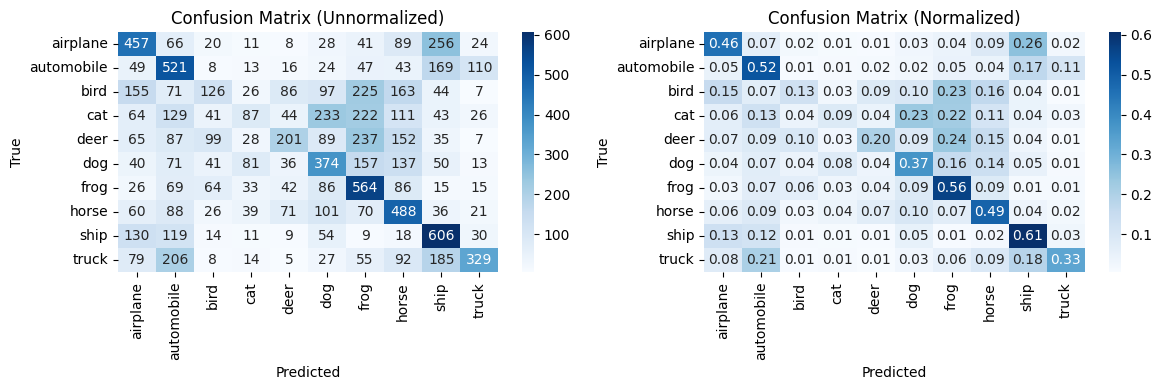


Randomly Select 10 Samples for Testing:


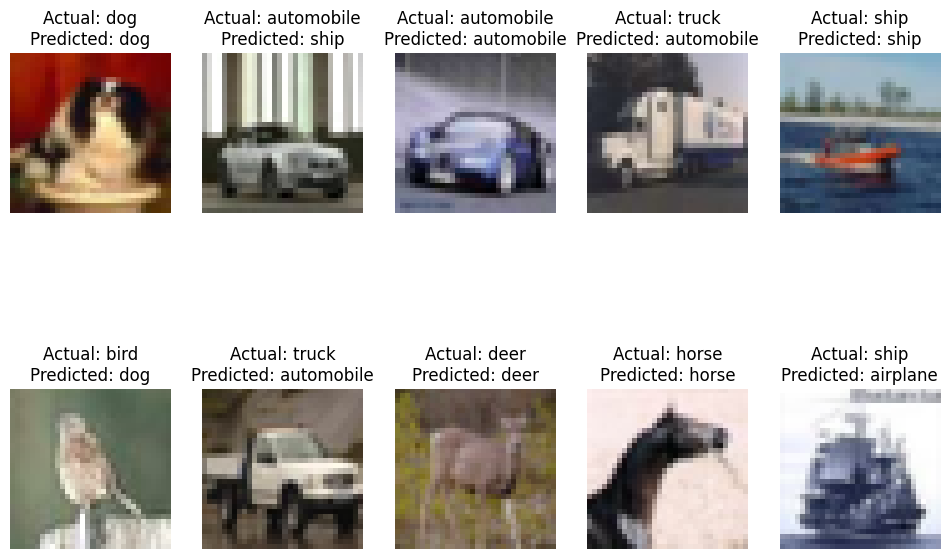

{'hidden_dims': [512, 256, 16], 'activations': [ReLU(), ReLU(), ReLU()], 'learning_rate': 0.01, 'optimizer': 'SGD'}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.8088817481994628, Training Accuracy: 38.3175%, Validation Accuracy: 44.5%
Epoch 2, Loss: 1.5283419688224793, Training Accuracy: 46.265%, Validation Accuracy: 48.25%
Epoch 3, Loss: 1.4203084353923798, Training Accuracy: 49.9125%, Validation Accuracy: 49.57%
Epoch 4, Loss: 1.3379938168525696, Training Accuracy: 52.7525%, Validation Accuracy: 50.91%
Epoch 5, Loss: 1.2753720122337342, Training Accuracy: 54.7975%, Validation Accuracy: 52.37%
Epoch 6, Loss: 1.2186504880905151, Training Accuracy: 57.0175%, Validation Accuracy: 51.53%
Epoch 7, Loss: 1.1697055275440216, Training Accuracy: 58.9125%, Validation Accuracy: 53.56%
Epoch 8, Loss: 1.119738101863861, Training Accuracy: 60.47%, Validation Accuracy: 52.64%
Epoch 9, Loss: 1.0765151223659515, Training Accuracy: 62.1975%, Validation Ac

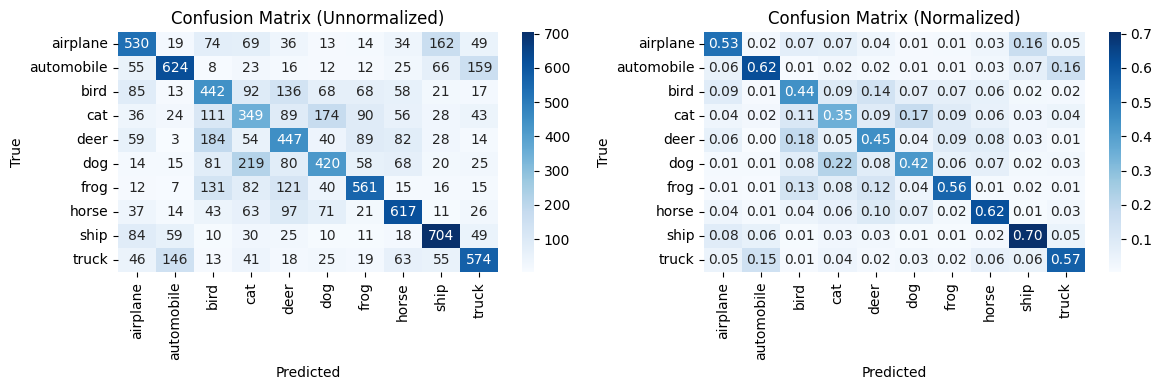


Randomly Select 10 Samples for Testing:


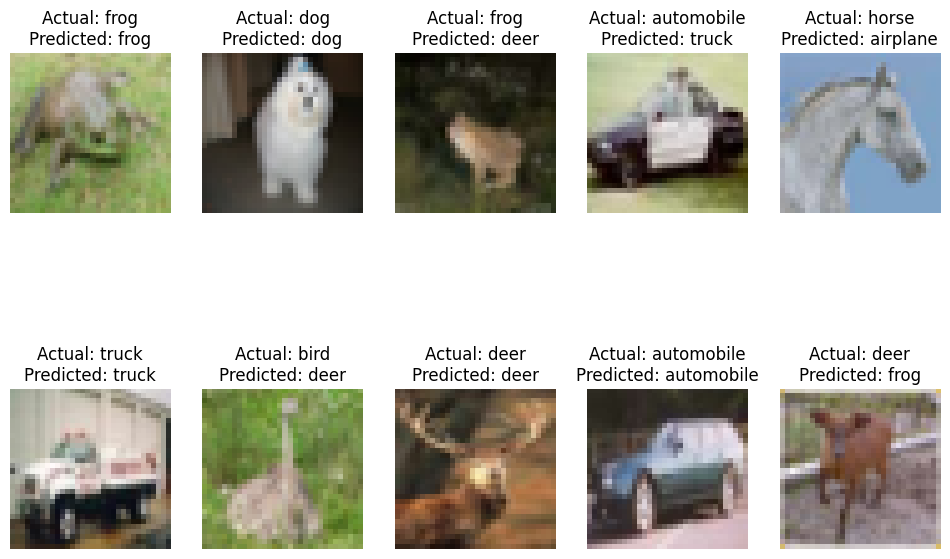

In [ ]:
if __name__ == "__main__":
    # CIFAR-10 input dimension
    input_dim = 3 * 32 * 32
    output_dim = 10

    # Define a list of hyperparameter configurations (cases)
    hyperparameter_cases = [
        {    'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256],
            'activations': [nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.01,
            'optimizer': 'SGD'
        },
        {
            'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256],
            'activations': [nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.01,
            'optimizer': 'adam'
        },
        {
            'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256],
            'activations': [nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.001,
            'optimizer': 'adam'
        },
        {
            'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256, 16],
            'activations': [nn.ReLU(), nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.01,
            'optimizer': 'adam'
        },
        {
            'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256, 16],
            'activations': [nn.ReLU(), nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.01,
            'optimizer': 'SGD'
        },
        # Add more cases here with different hyperparameters
    ]

    # Loop through the hyperparameter cases
    for case in hyperparameter_cases:
        print('='*80)
        print(case)
        print('='*80)

        batch_size = case['batch_size']
        num_epochs = case['num_epochs']
        hidden_dims = case['hidden_dims']
        activations = case['activations']
        learning_rate = case['learning_rate']
        optimizer_option = case['optimizer']

        main_sai(optimizer_option, batch_size, num_epochs, input_dim, hidden_dims, activations, output_dim, learning_rate)

## 6 Questions and exercises

### 6.1 Exercises (40 points)

E1. Using the original file and variables, discuss the overall results of the training. Overall, the system did not do well with an accuracy of just over 50% and the confusion matrices given above. In what situations did the system perform poorly or better? Is the system overfit or underfit? Give two approaches that might help improve system performance based on the results.

> Answer: Given the note book results: Training Accuracy: 60.4475%, Validation Accuracy: 52.98%, and Test Accuracy: 52.96%. Yes, the system did not do well, with just over 50% accuracy. When I increased epochs, I observed that the Training accuracy increased by 80%, but the validation and test accuracies didn't change much. So, it resembles the model is getting overfit. Moreover, the CIFAR-10 dataset is an image dataset (2-D), and the linear neural network models perform poorly for such a dataset. Hence, various neural network models have evolved to address the problem and developed convolutional neural network-based models. I have conducted a literature survey and found various models that can exhibit approximately 95% accuracy for the CIFAR-10 dataset. We can get the code scripts, and models can be found at https://github.com/kuangliu/pytorch-cifar. I have experimented with these code scripts, but I didn't reflect here as I am still learning convolutional network concepts from the course lectures. I tried experimenting to get relatively better results with only the FC linear neural network-based models. Some of the approaches are tunining the following hyper parameters (i) number of hidden layers, (ii) hidden layer dimensions, (iii) optimizer algorithm with weight_decay and scheduling, (iv) batch normalization as a regularization, and (v) learning rate.

E2. Implement one of your approaches in the code. Be sure to highlight what you did and describe it in words in this section. (you can change models, learning rates, optimization, add in regularization, train for different times,etc.) Comment on **why** you made each change. Give the setup that gave you the **best** results in your Python Notebook file with the run results saved.

>Answer: After conducting multiple experiments, I have refined the code scripts (2a, 4a, and 5a above) to encompass a comprehensive hyperparameter tuning strategy. This strategy includes optimizing the (i) number of hidden layers, (ii) hidden layer dimensions, (iii) choice of optimizer algorithm with weight decay and scheduling, (iv) incorporation of batch normalization as a regularization technique, and (v) fine-tuning the learning rate. I have meticulously constructed code scripts to iterate through various scenarios with distinct hyperparameter configurations. As an illustration, consider the scenario where (i) 'hidden_dims' consists of [512, 256], (ii) 'activations' are defined as [ReLU(), ReLU()], (iii) 'learning_rate' is set to 0.01, (iv) 'optimizer' is 'SGD' with weight decay set to 5*10^4, and (v) a CosineAnnealingLR scheduler with T_max=200 is employed. The 'weight_decay' property effectively combats overfitting. My comparative analysis has yielded notably improved results compared to the initial assignment hyperparameters, with the following outcomes: Training Accuracy: 66.5225%, Validation Accuracy: 54.53%, and Test Accuracy: 53.74%.

E3. Compare the difference in the results obtained from two different optimizers. when might you choose one over the other, and why?

>Answer: Through a careful comparison of results obtained from both the Adam and SGD optimizers, considering different network architectures and learning rates, I found that SGD consistently outperformed the Adam optimizer. Here's a concise summary of their characteristics:
> * SGD (Stochastic Gradient Descent): SGD is straightforward to implement and comprehend. It often excels, especially when coupled with proper learning rate scheduling. It's a valuable choice when computational resources are limited or when extensive hyperparameter tuning is required.

> * Adam (Adaptive Moment Estimation): Adam converges rapidly and is renowned for its robust performance across diverse tasks. It can be a reliable default choice for many applications, often eliminating the need for meticulous fine-tuning of learning rates and other hyperparameters.

>* For CIFAR-10: CIFAR-10, comprised of 32x32 color images across 10 classes, presents unique challenges due to its size and complexity. While SGD is initially favored for its strong performance on such datasets, optimizing it still necessitates careful tuning of learning rates and hyperparameters. In summary, while Adam serves as a solid default choice for CIFAR-10, my experiments have revealed that SGD consistently performs better. Notably, linear fully connected models yielded only approximately 50% accuracy, rendering them inefficient for CIFAR-10's 2-D image data. As a next step, I plan to explore convolutional networks, specifically designed for 2D image datasets like CIFAR-10, to potentially address the limitations of linear fully connected models.

### 6.2 Conceptual Questions: (10 Points)

C1. A “loss landscape” of your neural network’s loss function has a plateau shape, in
which there are large areas where the loss is flat. This means the gradient signal will be weak and gradient descent will not update the network parameters very much in each iteration. What are two activation functions that may cause such a problem, and one activation function that will not?

>Answer: Two activation functions that may cause a plateau-shaped loss landscape with vanishing gradients are Sigmoid and Tanh. Sigmoid compresses input into [0, 1], with gradients approaching zero far from zero input. Tanh, similar to Sigmoid, confines input to [-1, 1] with vanishing gradients in flat regions. In contrast, Rectified Linear Unit (ReLU) is less prone to this issue. ReLU, max(0, x), remains computationally efficient and avoids vanishing gradients, making it a preferred choice for deep networks, though it can encounter the "exploding gradient" problem in some cases.

C2. Which methods may help accelerate the optimization of a model that uses batch gradient descent?
a. Using Adam.
b. Fine tuning the learning rate using grid search.
c. Initializing all the weights to zero.
d. Using mini-batch gradient descent.

>Answer: So, among the given options, a, b, and d can help accelerate optimization when using batch gradient descent, while c is not a recommended practice. Adam, an adaptive optimization algorithm, converges faster than traditional batch gradient descent methods and also adapts learning rates on a per-parameter basis, improving optimization efficiency. In case of (b), fine-tuning it using techniques like grid search helps find an optimal learning rate, which can significantly speed up convergence, as adjusting the learning rate is crucial for optimizing a neural network. In case of (d), mini-batch gradient descent, as opposed to batch gradient descent, updates model parameters more frequently using smaller subsets of the data (mini-batches). This parallelism and reduced noise in gradient estimates make it a faster and more efficient optimization method.

> In the case of (c), initializing all weights to zero is not recommended as it leads to symmetry issues in neural networks, hindering convergence. Weight initialization techniques like Xavier/Glorot initialization are preferred to avoid such problems.

C4. Which statements are true about the step size in gradient descent?
a. The step size is the learning rate times the magnitude of the gradient.
b. If the step size is too big, gradient descent may oscillate leading to slow or unstable convergence.
c. The smaller the step size, the faster we can reach the optimal minima.

>Answer: Both (a) and (b) are True.


C5. State if each statement is true or false and give a brief reason

A). L2 regularization encourages sparse weights.

B) You notice that while training your neural network the test loss initially decreases but then starts increasing, while training loss continues to decrease. This means that test loss will only continue to increase if we train further.

> Answer:
> * A) False. L2 regularization encourages weight values to be small but non-zero, not sparse weights.

> * B) True. Increasing test loss while training loss decreases suggests overfitting, and continuing training is likely to worsen generalization.


C3. Compute the value of the function f(θ)=(θ-1)^4 after updating θ in one step of gradient descent, for θ = 4 and η=0.01. Does it look like the algorithm will converge to an optimum value of the function? Why or why not?

>Answer: After executing the code snippet provided below for the given values, the function value after one step of gradient descent is approximately 13.58. As for whether the algorithm will converge to an optimum value depends on the initial condition and eta (learning rate). In our case, we started with θ = 4 and η=0.01 (small learning rate). For the given function, a global minimum where f(θ) = 0 is at θ=1, and we started at θ=4. The algorithm is moving in the right direction towards the minimum. If we continue to update θ using gradient descent, it will eventually converge to the optimum value at θ = 1, where f(θ) = 0.





In [ ]:
#Computation for the C3 question above
# Given values
theta_old = 4
eta = 0.01

# Compute the gradient of the function
gradient = theta_old * (theta_old - 1) ** 3

# Update theta
theta_new = theta_old - eta * gradient

# Compute the new function value
function_value = (theta_new - 1) ** 4

theta_new, function_value


(2.92, 13.589544959999998)